In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_geometric import data
from torch_geometric.loader import DataLoader
import wandb
import torch.nn.functional as F
import time
import pickle
import pandas as pd

In [6]:
%run model.ipynb
%run utils.ipynb
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device='cpu'

In [10]:
# Set training parameters
learning_rate = 1e-3
batch_size = 128
num_epochs = 100
patience = 5
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="AML_GNN",

    # track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "architecture": "GNN",
        "dataset": "dummy",
        "epochs": num_epochs,
    }
)

wandb: Currently logged in as: radu-gaghi (caceu). Use `wandb login --relogin` to force relogin


In [17]:
# x = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
# y = torch.tensor([[1, 0], [0, 1], [0, 1], [1, 0]])
# edge_index = torch.tensor([[0, 2],[1, 3]])
filename ="1dNode_4dEdge_HI_SMALL"
G = pickle.load(open(filename + '.pickle', 'rb'))
df = pd.read_csv('./Data/HI-Small_Trans.csv')
ys = torch.tensor(df["Is Laundering"])

In [16]:
from sklearn.model_selection import train_test_split
def random_split_ind(new_nodes, new_edges, train_size, test_size, device, seed = 42):
    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep only the node-induced edges within
    each set.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set
        device        Computing device
        seed          Random seed for data splitting

    Returns:
        data          A dictionary that stores training, validation, and test set
                        each value is one Data object
    """
    ## Create PyG graph separated by time (merge graphs in each set in train/val/test).
    features =  torch.FloatTensor(df.to_numpy())
    labels = ys
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = torch.FloatTensor(new_nodes.to_numpy())
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))

    # Create random splitting node indices.
    nodes_id_train, nodes_id_test, train_idx, test_idx = \
        train_test_split(nodes_id, range(nodes_id.shape[0]), test_size = 1 - train_size,
                         random_state = seed)
    nodes_id_valid, nodes_id_test, val_idx, test_idx = \
        train_test_split(nodes_id_test, test_idx, test_size = test_size / (1 - train_size),
                         random_state = seed)
    features_set = {'train': features[train_idx], 'val': features[val_idx],
                    'test': features[test_idx]}
    labels_set = {'train': labels[train_idx], 'val': labels[val_idx],
                  'test': labels[test_idx]}

    # Find the induced edge indices by the given node indices.
    id2idx = {}
    for i in range(nodes_id_train.shape[0]):
        id2idx[int(nodes_id_train[i])] = (i, 'train')
    for i in range(nodes_id_valid.shape[0]):
        id2idx[int(nodes_id_valid[i])] = (i, 'val')
    for i in range(nodes_id_test.shape[0]):
        id2idx[int(nodes_id_test[i])] = (i, 'test')

    edge_index = {'train': [], 'val': [], 'test': []}
    for i in range(new_edges.shape[0]):
        node1 = id2idx[new_edges.iloc[i, 0]]
        node2 = id2idx[new_edges.iloc[i, 1]]
        if (node1[-1] == 'train' and node2[-1] == 'train'):
            edge_index['train'].append([node1[0], node2[0]])
        elif (node1[-1] == 'val' and node2[-1] == 'val'):
            edge_index['val'].append([node1[0], node2[0]])
        elif (node1[-1] == 'test' and node2[-1] == 'test'):
            edge_index['test'].append([node1[0], node2[0]])

    data = {}
    for name in ['train', 'val', 'test']:
        edge_index[name] = torch.LongTensor(edge_index[name]).t()
        data[name] = Data(x = features_set[name], edge_index = edge_index[name],
                          y = labels_set[name]).to(device)
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']

    return data
# y = df = F.one_hot(ys, num_classes=2)
# dataset = [data.Data(G.nodes, y=y, edge_index=G.edges)]
nodes = G.nodes
edges = G.edges
train_node_size = 0.8
test_node_size = 0.2
dataset = random_split_ind(nodes, edges, train_size = train_node_size,
                         test_size = test_node_size, device = device)
dataset

AttributeError: 'NodeView' object has no attribute 'to_numpy'

In [15]:


train_loader = DataLoader(dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
for batch in train_loader:
    print(batch)

KeyboardInterrupt: 

In [32]:
node_dim = 2
edge_dim = 1
output_dim = 2
hidden_dim = 4
n_gnn_layers = 3
K = 1
dropout_rate = 0.0

# Create model
model = GNN_Example(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate).to(device)
print(model)

GNN_Example(
  (dropout): Dropout(p=0.0, inplace=False)
  (relu): PReLU(num_parameters=1)
  (convs): ModuleList(
    (0): TAGConv(2, 4, K=1)
    (1): TAGConv(4, 4, K=1)
    (2): TAGConv(4, 2, K=1)
  )
)


In [33]:
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
train_losses, validation_losses = train(num_epochs, model, train_loader, val_loader, optimizer, criterion, device, patience)

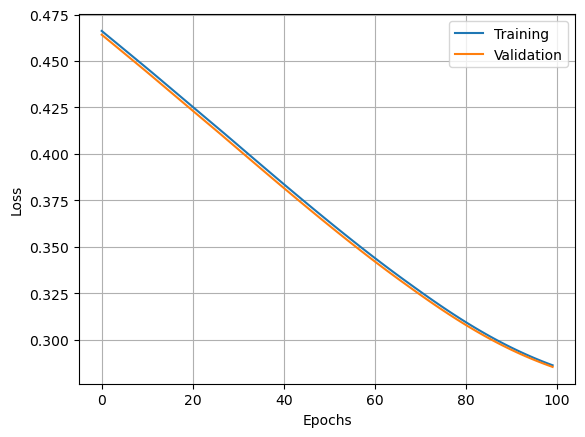

In [24]:
plt.grid()
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()